# Evaluate predictions on HotpotQA
- Model predicts weather a sentence is a supporting fact to answer a question
- This notebook rearranges the predictions and evaluates the performance just like the hotpot evaluation script

In [1]:
import random
import math
import os
import pickle
from tqdm import tqdm, trange
import numpy as np

import sklearn
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pdb

In [2]:
import warnings
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [3]:
from pytorch_pretrained_bert import BertTokenizer

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
def pickler(path,pkl_name,obj):
    with open(os.path.join(path, pkl_name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def unpickler(path,pkl_name):
    with open(os.path.join(path, pkl_name) ,'rb') as f:
        obj = pickle.load(f)
    return obj

In [6]:
data_pkl_path = "../../data/hotpot/"
data_pkl_name = "preprocessed_dev.pkl"
predictions_pkl_path = "./"
predictions_pkl_name = "predictions.pkl"

In [7]:
def exact_match(gt, pred):
    assert(len(gt) == len(pred))
    total_size = len(pred)
    num_correct = 0
    for i in range(total_size):
        if(gt[i] == pred[i]):
            num_correct += 1
    return num_correct/total_size

In [8]:
def score(gt, pred):
    assert(len(gt) == len(pred))
    total_size = len(pred)
    assert(len(gt) != 0)
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_correct = 0
    for i in range(total_size):
        if(gt[i] == pred[i]):
            total_correct += 1
        p = precision_score(gt[i], pred[i],average="binary")
        r = recall_score(gt[i], pred[i],average="binary")
        total_precision += p
        total_recall += r
        total_f1 += 2*(p*r)/(p+r) if (p+r)>0 else 0
    return {"precision":total_precision/total_size, "recall":total_recall/total_size, 
            "f1":total_f1/total_size, "em":total_correct/total_size}

In [9]:
def reorganize_predictions(predictions, document_lengths):
    out_list = []
    start_index = 0
    for i in range(len(document_lengths)):
        p = predictions[start_index:start_index+document_lengths[i]]
        out_list.append(p)
        start_index += document_lengths[i]
    return out_list

In [10]:
dataset = unpickler(data_pkl_path, data_pkl_name)

In [11]:
dataset.keys()

dict_keys(['sequences', 'segment_ids', 'supporting_fact', 'document_lengths'])

In [12]:
predictions_raw = unpickler(predictions_pkl_path, predictions_pkl_name)

In [13]:
type(predictions_raw)

numpy.ndarray

In [14]:
predictions_raw.shape

(306423,)

In [15]:
predictions_raw[:20]

array([-9.601742 , -9.663979 , -9.62248  ,  6.0936594, -6.900798 ,
       -8.023089 , -9.544183 , -9.211874 , -9.660895 , -9.671396 ,
       -9.670813 , -7.9406586, -8.569448 , -9.456178 , -9.541397 ,
       -6.732898 ,  6.1708226, -9.580299 , -9.654386 , -9.556057 ],
      dtype=float32)

In [16]:
def evaluate(gt, pred, threshold, document_lengths):
    pred_answer_labels = (torch.sigmoid(torch.tensor(pred)) > threshold).numpy().tolist()
    predictions_reorganized = reorganize_predictions(pred_answer_labels, document_lengths)
    supporting_facts_reorganized = reorganize_predictions(gt, document_lengths)
    result = score(supporting_facts_reorganized, predictions_reorganized)
    return result

In [17]:
metrics = {'precision':[], 'recall':[], 'f1':[], 'em':[]}
for t in tqdm(np.linspace(0.1,1,18,endpoint=False)):
    result = evaluate(dataset['supporting_fact'], predictions_raw, t, dataset['document_lengths'])
    for key,value in result.items():
        metrics[key].append(value)

100%|██████████| 18/18 [03:41<00:00, 12.22s/it]


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
metric_df = pd.DataFrame(metrics, index=np.linspace(0.1,1,18,endpoint=False))

In [20]:
metric_df

,precision,recall,f1,em
0.10,0.640663,0.853611,0.698550,0.231767
0.15,0.676581,0.828820,0.711917,0.259860
0.20,0.701051,0.805753,0.717206,0.275797
0.25,0.721589,0.784760,0.719761,0.293490
0.30,0.737657,0.766299,0.720213,0.305646
0.35,0.750505,0.749030,0.718462,0.312264
0.40,0.762208,0.730943,0.715151,0.321043
0.45,0.770316,0.711010,0.708521,0.326040
0.50,0.777286,0.690953,0.700562,0.324149
0.55,0.783196,0.670106,0.691138,0.320097


<Figure size 432x288 with 0 Axes>

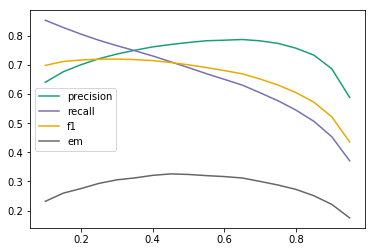

In [21]:
plt.figure(); metric_df.plot(colormap="Dark2");

### Evaluation

## Examples of correct and incorrect predictions

In [22]:
import seaborn as sns

/home/bhargav/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


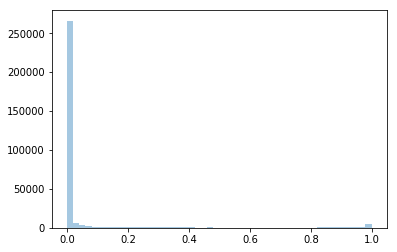

In [23]:
sns.distplot((torch.sigmoid(torch.tensor(predictions_raw))).numpy(),kde=False, hist=True, rug=False)

In [39]:
threshold = 0.4

In [40]:
pred_answer_labels = (torch.sigmoid(torch.tensor(predictions_raw)) > threshold).numpy().tolist()

In [41]:
# for individual question sentence pairs
wrong_prediction_indices = []
correct_prediction_indices = []
for i in range(len(dataset["supporting_fact"])):
    if( dataset["supporting_fact"][i] != pred_answer_labels[i]):
        wrong_prediction_indices.append(i)
    else:
        correct_prediction_indices.append(i)

In [42]:
len(wrong_prediction_indices)

10055

In [43]:
len(correct_prediction_indices)

296368

In [44]:
def get_q_s_pair(index, dataset):
    token_ids = dataset["sequences"][index]
    true_label = dataset["supporting_fact"][index]
    words = tokenizer.convert_ids_to_tokens(token_ids)
    return {"sequence":" ".join(words),"true_label":true_label} 

def sort_indices_increasing_confidence(indices, scores, threshold):
    margins = []
    for index in indices:
        m = scores[index] - threshold
        margins.append(m)
    return np.argsort(np.absolute(margins)), np.absolute(margins)
        

In [45]:
print(get_q_s_pair(wrong_prediction_indices[1], dataset))

{'sequence': '[CLS] what government position was held by the woman who portrayed co ##rl ##iss archer in the film kiss and tell ? [SEP] as an adult , she was named united states ambassador to ghana and to czechoslovakia and also served as chief of protocol of the united states . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'true_label': 1}


### Least and most confident wrong predictions

In [46]:
sigmoid_scores = (torch.sigmoid(torch.tensor(predictions_raw))).numpy()

In [47]:
incorrect_confidences_sorted, incorrect_margins = sort_indices_increasing_confidence(wrong_prediction_indices, sigmoid_scores, threshold)

In [48]:
print(get_q_s_pair(wrong_prediction_indices[incorrect_confidences_sorted[0]], dataset))
print("margin: ",incorrect_margins[incorrect_confidences_sorted[0]])

{'sequence': '[CLS] when was the anthology , in which fis ##rt pages of the inca ##l " were released , created ? [SEP] the inca ##l ( french : " l \' inca ##l " ) is a french graphic novel series written by alejandro jo ##dor ##ows ##ky and originally illustrated by jean gi ##ra ##ud . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'true_label': 1}
margin:  2.0587444305442126e-05


In [49]:
print(get_q_s_pair(wrong_prediction_indices[incorrect_confidences_sorted[-1]], dataset))
print("margin: ",incorrect_margins[incorrect_confidences_sorted[-1]])

{'sequence': '[CLS] eleventh dream day and the shin ##s are both rock bands from where ? [SEP] the shin ##s are an american indie rock band from albuquerque , new mexico , formed in 1996 . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'true_label': 0}
margin:  0.5976620674133301


### Least and most confident correct predictions

In [50]:
correct_confidences_sorted, correct_margins = sort_indices_increasing_confidence(correct_prediction_indices, sigmoid_scores, threshold)

In [51]:
print(get_q_s_pair(correct_prediction_indices[correct_confidences_sorted[0]], dataset))
print("margin: ",correct_margins[correct_confidences_sorted[0]])

{'sequence': '[CLS] what was rosario dawson of josie and the pussy ##cats film debut [SEP] josie and the pussy ##cats is a 2001 american musical comedy film released by universal pictures , and metro - gold ##wyn - mayer . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'true_label': 0}
margin:  0.00018634796142580345


In [53]:
print(get_q_s_pair(correct_prediction_indices[correct_confidences_sorted[-1]], dataset))
print("margin: ",correct_margins[correct_confidences_sorted[-1]])

{'sequence': '[CLS] between harvey pe ##kar and denise lever ##tov who was born earlier ? [SEP] harvey lawrence pe ##kar ( ; october 8 , 1939 – july 12 , 2010 ) was an american underground comic book writer , music critic , and media personality , best known for his autobiographical " american sp ##len ##dor " comic series . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'true_label': 1}
margin:  0.5985417127609253
